# Lab exercise #2: Gaussian process basics 

CS-E4075, 2021

### Learning objectives

After completing this lab exercise, you should be able to:

- Implement the squared exponential kernel and explain the interpretation of each parameter


- Generate samples from a Gaussian process prior


- Compute the posterior & predictive distributions for a Gaussian process model with Gaussian likelihood


- Compute the marginal likelihood and use it for model selection

All exercises must be solved using numpy only.


In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
import seaborn as snb
snb.set(font_scale=1.5)

### Task 1: The squared exponential kernel

The squared exponential covariance function is given by

\begin{align}
    k(\mathbf{x}_n, \mathbf{x}_m) = \alpha \exp\left(-\frac{\|\mathbf{x}_n - \mathbf{x}_m\|^2_ 2}{2\ell^2}\right),
\end{align}

where $\alpha > 0$ and $\ell > 0$ are hyperparameters of the kernel. This specific covariance function is perhaps the most common covariance function used in statistics and machine learning. It is also known as the radial basis function kernel, the gaussian kernel, or the exponeniated quadratic kernel. 

Below you are given a vector $\mathbf{X}^p \in \mathbb{R}^{N \times 1}$ of $N = 50$ points on the real line. The points are sorted and equidistantly distributed in the interval $\left[-3, 9\right]$. 

- **Task 1a**: Complete the implementation of the squared exponential kernel function below. (Hint: the code only needs to work with $D=1$).

- **Task 1b**: Use the kernel function to compute the $N\times N$ kernel matrix for the points $\mathbf{X}^p$ with $\alpha=1$ and $\ell=1$. These points will be used for predictions later and hence, the superscript 'p'. Visualize the kernel function as an image and give an interpretation of the structure of the kernel. ('imshow' function)

- **Task 1c**: Try few other parameter values $\alpha, \ell$ and explain how they affect the structure of the kernel.

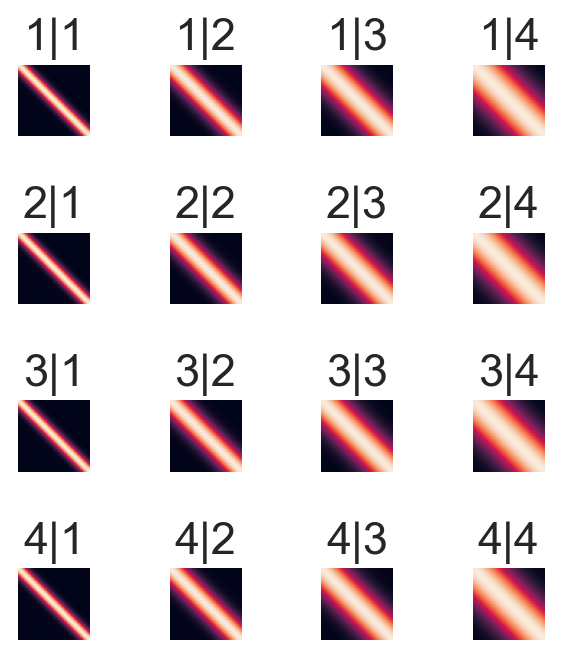

In [2]:
# create an Nx1 vector of equidistant points in [-3, 3]
N = 50
Xp = np.linspace(-3, 9, N)[:, None]


def create_se_kernel(X1, X2, alpha=1, scale=1):
    """ returns the NxM kernel matrix between the two sets of input X1 and X2 
    
    arguments:
    X1    -- NxD matrix
    X2    -- MxD matrix
    alpha -- scalar
    scale -- scalar
    
    returns NxM matrix
    """
    kernel_matrix = np.zeros((X1.shape[0],X2.shape[0]), dtype=float)
    for x1_idx, x1 in enumerate(X1):
        for x2_idx, x2 in enumerate(X2):
            # norms = np.linalg.norm(x1-x2)
            norms = np.sum((x1-x2)**2)
            kernel_matrix[x1_idx][x2_idx] = alpha * np.exp(-0.5 * norms/(scale**2))
    return kernel_matrix
    # return alpha * np.exp(-0.5 * norms/(scale**2))
    ###############################################
    # ------- insert code here -------------------
    ###############################################

kernel_matrix = create_se_kernel(Xp,Xp,1,1)
# 1b & 1c

plt.figure(dpi=180,figsize=(4,4))

for r in range(4):
    for c in range(4):
        plt.subplot(4,4,r*4+c+1)
        plt.axis('off')
        plt.title(f'{r+1}|{c+1}')
        plt.imshow(create_se_kernel(Xp,Xp,r+1,c+1))
        plt.tight_layout()

plt.show()


- The alpha $alpha$ controls the variace of the kernel matrix. Larger alpha value leads towards to larger variance (larger distance between points)
- The scaler $l$ decides when 2 points cound be defined as with high variance. Larger scaler means the higher possibility of 2 similar inputs with high covariance.   

### Task 2: Sampling from a Gaussian process

We will consider a zero-mean Gaussian process prior for functions of the form $f: \mathbb{R} \rightarrow \mathbb{R}$ using the squared exponential kernel from task 1). That is,

\begin{align}
f(x) \sim \mathcal{GP}\left(0 \, , \, k\left(x, x'\right)\right).
\end{align}

Let $f_n = f(x_n) \in \mathbb{R}$ be the value of the function $f$ evaluated at a point $x_n \in \mathbb{R}$. Furthermore, let $\mathbf{f} = \left[f_1, f_2, \dots, f_N\right] \in \mathbb{R}^{N \times 1}$ be the vector of function values for each of the points of $\mathbf{X}^p$ from task 1. 

The Gaussian process prior for $\mathbf{f}$ becomes

\begin{align}
\mathbf{f} \sim \mathcal{N}\left(\mathbf{0}, \mathbf{K}\right),
\end{align}

where $\mathbf{K}$ is the kernel matrix you generated previously.

- **Task 2a**: Complete the implementation of the sampling function given below. Hint: You can re-use the code from first exercise.


- **Task 2b**: Generate $M = 10$ samples using the new function and plot them


- **Task 2c**: Change the parameters $\alpha, \ell$ and explain how they affect the generated samples.


In [3]:
def get_inv(A):
    return np.linalg.inv(A) if isinstance(A, np.ndarray) else A**(-1)

def mvn_pdf(x, mu, Sigma, log=True):
    """ Returns the log density of a multivariate Gaussian distribution
    with mean mu and covariace Sigma at point x
    
    Arguments:
    x     -- (Dx1) evaluation point
    mu    -- (Dx1) mean vector
    Sigma -- (DxD) covariance matrix
    log   -- (bool) if true, return log density. If false, return (default=True)
      
    Returns:
    (scalar) density
    """

    D = x.shape[0]
    x_mu = x - mu
    inv_sigma = get_inv(Sigma)
    det_sigma = np.linalg.det(Sigma) if isinstance(Sigma, np.ndarray) else Sigma
    scaler = (-D/2) * np.log(2*np.pi) - 0.5 * np.log(det_sigma)

    x_mu_div_x_mu =  x_mu.T.dot(inv_sigma).dot(x_mu)
    res = scaler - 0.5 * x_mu_div_x_mu
    if not log:
        return np.exp(res)
    else:
        return res


def generate_samples(mean, K, M):
    """ returns M samples from a zero-mean Gaussian process with kernel matrix K
    
    arguments:
    K   -- NxN kernel matrix
    M   -- number of samples (scalar)
    
    returns NxM matrix
    """
    return np.random.multivariate_normal(mean,K,M).T
    ###############################################
    # ------- insert code here ------------------  -
    ###############################################
    

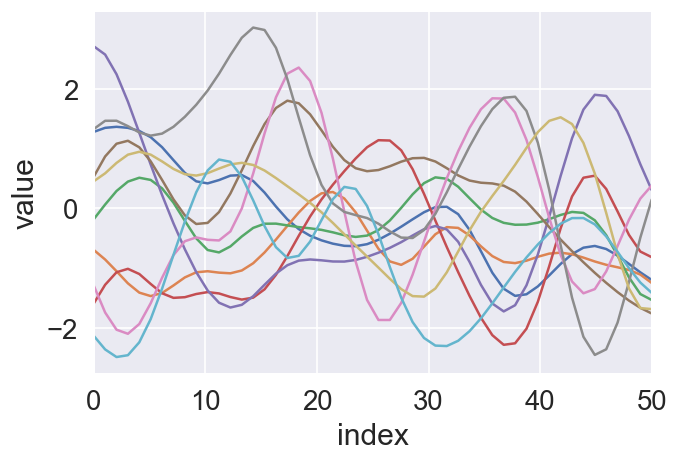

In [4]:

def plot_samples(samples):
    x = np.linspace(0,samples.shape[0])
    for i in range(samples.shape[1]):
        plt.plot(x, samples.T[i])
    plt.xlim((0, samples.shape[0]))
    plt.xlabel('index')
    plt.ylabel('value')

plt.figure(dpi=120)
plot_samples(generate_samples(np.zeros(kernel_matrix.shape[0]),kernel_matrix,10))
plt.show()

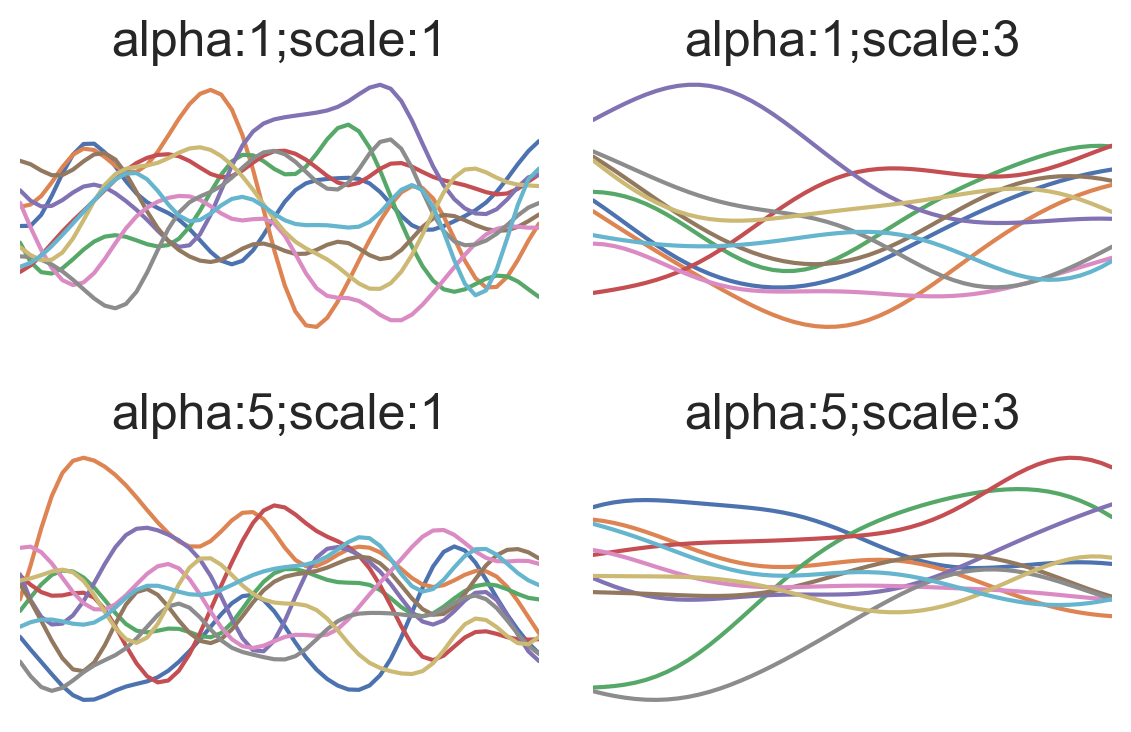

In [5]:
plt.figure(dpi=200)
for r in range(2):
    for c in range(2):
        plt.subplot(2,2,r*2+c+1)
        plt.axis('off')
        plt.title(f'alpha:{r*4+1};scale:{c*2+1}')
        kernel_matrix = create_se_kernel(Xp,Xp,r*4+1,c*2+1)
        plot_samples(generate_samples(np.zeros(kernel_matrix.shape[0]),kernel_matrix,10))
        plt.tight_layout()

plt.show()

## Larger $l$ makes the curve lines more smooth while larger $\alpha$ makes larger variance between samples, in another word larger distance between curve lines. 

### Task 3: The analytical posterior distribution

The goal of this task is complete the implementation of the function below for computing the analytical posterior distribution for a Gaussian process model with Gaussian likelihood, respectively, using the squared exponential kernel.

The joint model for the training data is as follows:
\begin{align}
p(\mathbf{y}, \mathbf{f}) = \mathcal{N}\left(\mathbf{y}|\mathbf{f}, \sigma^2 \mathbf{I}\right)\mathcal{N}\left(\mathbf{f} | \mathbf{0}, \mathbf{K}\right)
\end{align}





Below you are given a simple toy data set $\mathcal{D} = \left\lbrace x_n, y_n \right\rbrace_{n=1}^N$ for $N = 50$ as visualized below


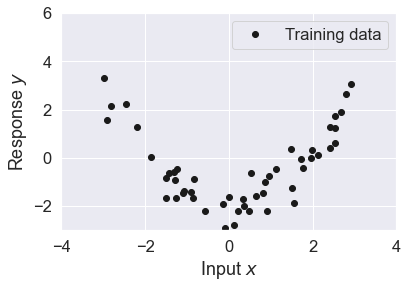

In [6]:
# load data
data = np.load('assignment2_data.npz')
N = data['N']
X = data['X']
y = data['y']

plt.plot(X, y, 'k.', markersize=12, label='Training data')
plt.grid(True)
plt.xlim((-4, 4))
plt.ylim((-3, 6))
plt.xlabel('Input $x$')
plt.ylabel('Response $y$')
plt.legend();


**Task 3a**: Complete the implementation of the function <tt>posterior</tt> that computes the posterior

\begin{align*}
p(f_* | X,y,X^p) = \mathcal{N} \left(f_* \big| K_{f_* f} K_{ff}^{-1} y, K_{f_* f_*} - K_{f_* f} K_{ff}^{-1} K_{f_* f}^T \right)
\end{align*}


In [33]:
def posterior(Xp, X, y, alpha, scale, sigma2):
    """ returns the posterior distribution of f evaluated at each of the points in Xp conditioned on (X, y)
        using the squared exponential kernel.
    
    Arguments:
    Xp    -- PxD prediction points
    X     -- NxD input points
    y     -- Nx1 observed values 
    alpha -- hyperparameter
    scale -- hyperparameter
    sigma2 -- noise variance
    
    returns Px1 mean vector and PxP covariance matrix
    """
    # kff = np.linalg.inv(create_se_kernel(Xp,Xp,alpha,scale) + sigma2 * np.identity(Xp.shape[0]))
    # kyf = create_se_kernel(X,Xp,alpha,scale)
    # kyy = create_se_kernel(X,X,alpha,scale)

    # mu = kyf.dot(kff).dot(y).flatten()
    # Sigma = kyy - kyf.dot(kff).dot(kyf.T)
    ###############################################
    # ------- insert code here -------------------
    ###############################################
    kff = np.linalg.inv(create_se_kernel(X,X,alpha,scale) + sigma2 * np.identity(X.shape[0]))
    kyf = create_se_kernel(Xp,X,alpha,scale)
    kyy = create_se_kernel(Xp,Xp,alpha,scale)

    mu = kyf.dot(kff).dot(y).flatten()
    Sigma = kyy - kyf.dot(kff).dot(kyf.T)

    return mu, Sigma



**Task 3b**: Compute the prior & posterior of $f(\mathbf{X}_p)$ with $\sigma^2 = \frac{1}{2}$, $\alpha=1$, and <tt>scale</tt>=2, where $\mathbf{X}_p$ is the vector from task 1.


In [8]:
sigma2 = 0.5
alpha = 1
scale = 1

kernel_matrix = create_se_kernel(Xp,Xp,alpha,scale)

# prior mean and covariance
mu_prior, Sigma_prior = np.zeros(Xp.shape[0]), kernel_matrix + sigma2*np.identity(Xp.shape[0])

# posterior mean and covariance
mu_post, Sigma_post = posterior(Xp, X, y, alpha, scale, sigma2)


**Task 3c**: If the functions above have been implemented correctly, then the following two plots below will show the training data superimposed with prior and posterior, respectively. First, explain what you see in the two figures. Second, what is the difference between the prior and the posterior in 1) regions close to the data points 2) in regions far from the data points?



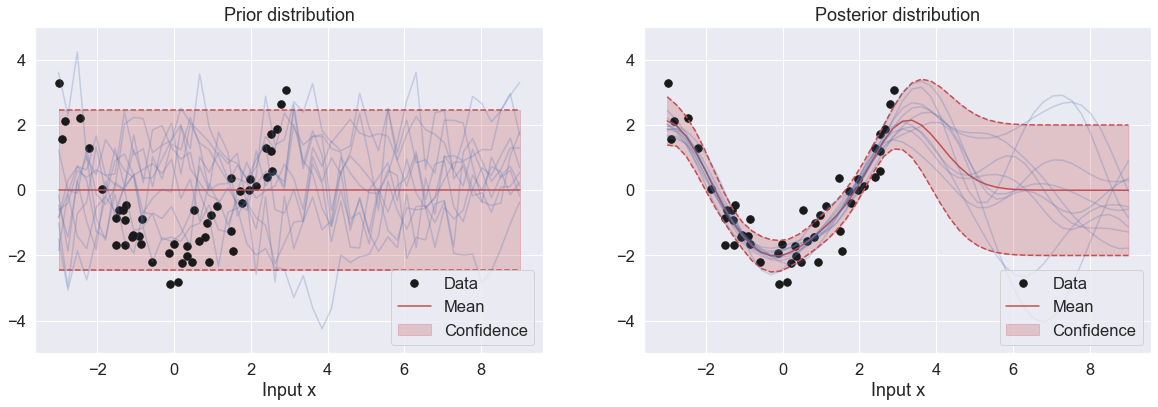

In [9]:
def plot_with_uncertainty(Xp, mu, Sigma, color='r', color_samples='b', title="", num_samples=0):
    
    mean, std = mu.ravel(), np.sqrt(np.diag(Sigma))

    
    # plot distribution
    plt.plot(Xp, mean, color=color, label='Mean')
    plt.plot(Xp, mean + 2*std, color=color, linestyle='--')
    plt.plot(Xp, mean - 2*std, color=color, linestyle='--')
    plt.fill_between(Xp.ravel(), mean - 2*std, mean + 2*std, color=color, alpha=0.25, label='Confidence')
    
    # generate samples
    if num_samples > 0:
        fs = generate_samples(mu, Sigma, 10)
        plt.plot(Xp, fs, color=color_samples, alpha=.25)
    
    plt.title(title)
    
def plot_data():
    plt.plot(X, y, 'k.', markersize=15, label='Data')
    plt.xlabel('Input x')
    plt.ylim((-5, 5))
    plt.grid(True)

def plot_set(mu_prior,Sigma_prior,mu_post,Sigma_post):
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plot_data()
    plot_with_uncertainty(Xp, mu_prior, Sigma_prior, title='Prior distribution', num_samples=10)
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plot_data()
    plot_with_uncertainty(Xp, mu_post, Sigma_post, title='Posterior distribution', num_samples=10)
    plt.legend(loc='lower right')
    

plot_set(mu_prior,Sigma_prior,mu_post,Sigma_post)



**Task 3d**: Replicate the two figures above for the following three different values of the scale parameter: $\left\lbrace 0.25, 1, 5 \right\rbrace$ and for $\sigma^2 = \frac{1}{2}$ and $\alpha=1$. Explain the differences between the three sets of plots


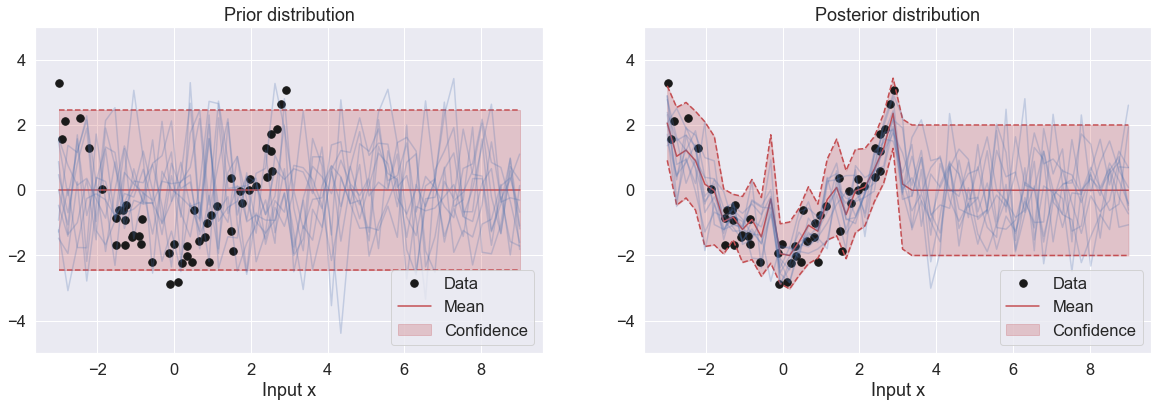

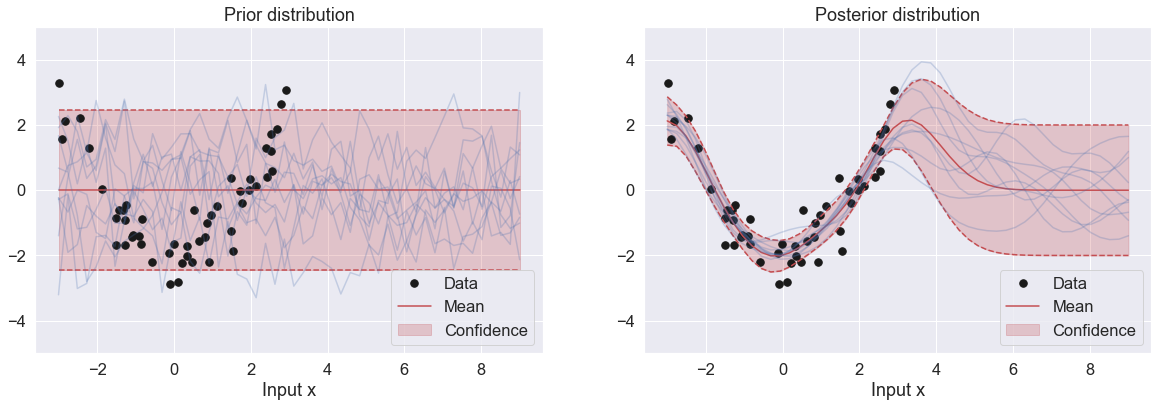

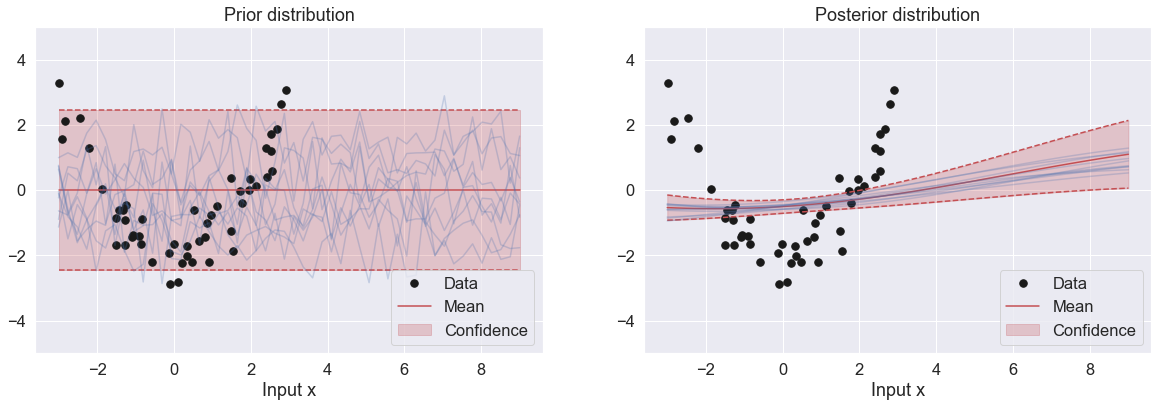

In [10]:
sigma2=0.5
alpha=1
scales = [0.1, 1., 10.]

for idx in range(len(scales)):
    kernel_matrix = create_se_kernel(Xp,Xp,alpha,scales[idx])
    # prior mean and covariance
    mu_prior, Sigma_prior = np.zeros(Xp.shape[0]), kernel_matrix + sigma2*np.identity(Xp.shape[0])
    # posterior mean and covariance
    mu_post, Sigma_post = posterior(Xp, X, y, alpha, scales[idx], sigma2)
    plot_set(mu_prior,Sigma_prior,mu_post,Sigma_post)

###############################################
# ------- insert code here -------------------
###############################################

## Larger scale parameter $l$ will compress the posterior distribution of $f$.

**Task 3e**: Replicate the two figures above for the following three different values of the alpa parameter: $\left\lbrace 0.25, 1, 5 \right\rbrace$ and for $\sigma^2 = \frac{1}{2}$ and $\text{scale}=1$. Explain the differences between the three sets of plots


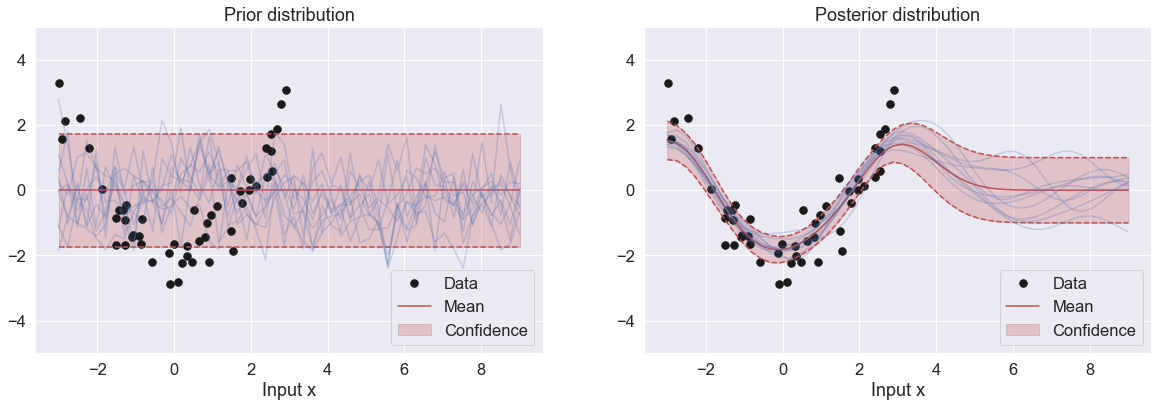

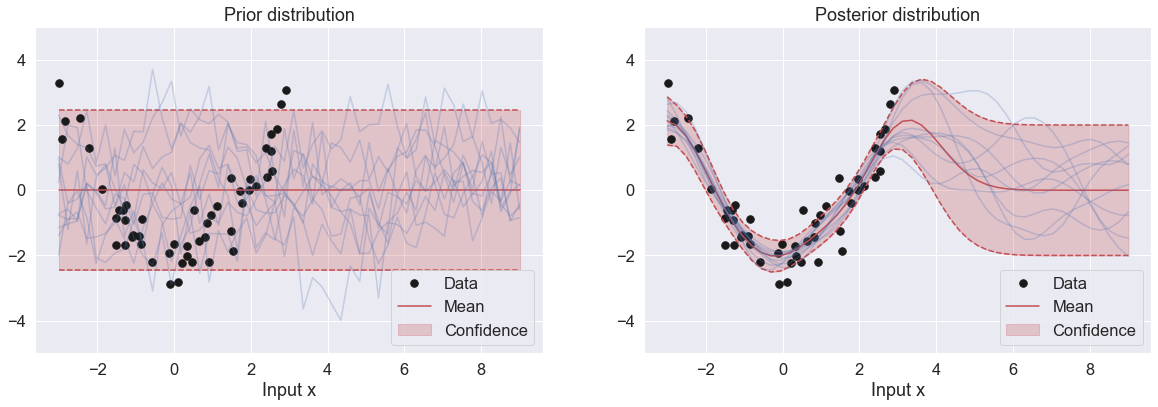

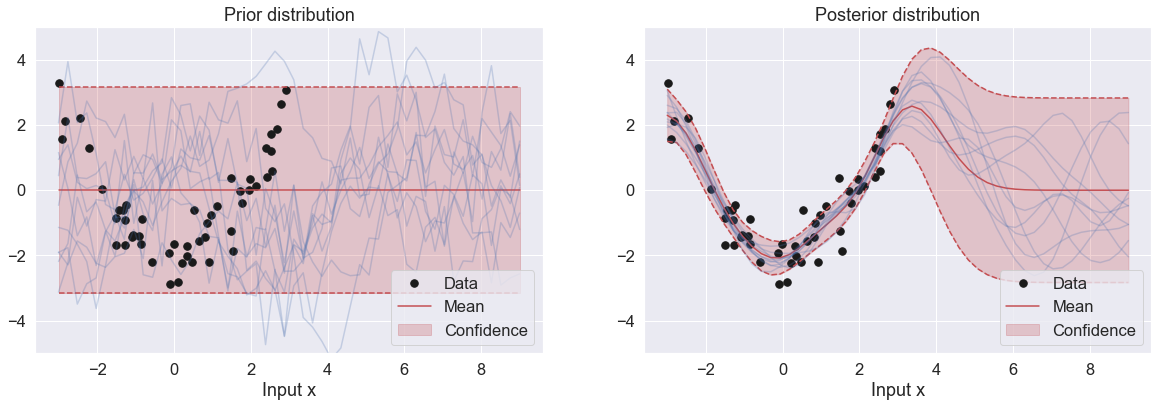

In [11]:
sigma2=0.5
scale=1
alphas = [0.25, 1., 2.]

for idx in range(len(alphas)):
    kernel_matrix = create_se_kernel(Xp,Xp,alphas[idx],scale)
    # prior mean and covariance
    mu_prior, Sigma_prior = np.zeros(Xp.shape[0]), kernel_matrix + sigma2*np.identity(Xp.shape[0])
    # posterior mean and covariance
    mu_post, Sigma_post = posterior(Xp, X, y, alphas[idx], scale, sigma2)
    plot_set(mu_prior,Sigma_prior,mu_post,Sigma_post)
###############################################
# ------- insert code here -------------------
###############################################

## Larger $\alpha$ parameter have larger inertia. As we can see from the chart that with larger alpha values, each sample points contribute much more effect on the coverage area of posterior

### Task 4: The marginal likelihood

The purpose of this task is to study the marginal likelihood $p(\mathbf{y})$ and see how it can be useful for model selection. 

The marginal likelihood is covered in lecture #3.

The marginal likelihood for a zero-mean Gaussian process model with Gaussian likelihood is given by

\begin{align}
p(\mathbf{y} \big| \theta) = \mathcal{N}\left(\bf{y} \big| \bf{0}, \bf{K} + \sigma^2 \bf{I}\right)
\end{align}

where $\theta$ are the set of hyperparameters, e.g. the alpha and scale parameters.

First, we will load some validation data that will be useful for evaluating the model.


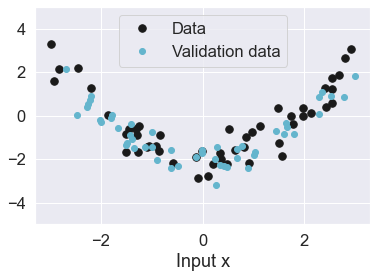

In [12]:
Nval, Xval, yval = data['Nval'], data['Xval'], data['yval']

plot_data()
plt.plot(Xval, yval, 'c.', label='Validation data', markersize=12)
plt.legend(loc='upper center');

**Task 4a**: Complete the implementation of the function <tt>predictive</tt> below. The predictive distribution of 'yp' combines prediction function posterior (<tt>posterior</tt>) and the noise variance.


In [36]:
def predictive(Xp, X, y, alpha, scale, sigma2):
    """ returns the predictive distribution of yp 
    evaluated at each of the points in Xp conditioned on (X, y)
    
    Arguments:
    Xp    -- PxD prediction points
    X     -- NxD input points
    y     -- Nx1 observed values 
    alpha -- hyperparameter
    scale -- hyperparameter
    sigma2 -- noise variance
    
    returns Px1 mean vector and PxP covariance matrix
    """
    
    ###############################################
    mu_post, Sigma_post = posterior(Xp, X, y, alpha, scale, sigma2)
    return mu_post, Sigma_post
    ###############################################


**Task 4b**: Complete the implementation of the function <tt>MLPPD</tt> for computing the mean log posterior predictive density given below.


In [37]:
log_npdf = lambda x, m, v: -0.5*(x-m)**2/v -0.5* np.log(2*np.pi*v)

def MLPPD(Xval, yval, mu, Sigma):
    """ returns the mean log posterior predictive density 
    for the data points (Xval, yval) wrt. predictive density N(mu, Sigma)
    
    Arguments:
    Xval      -- PxD input points
    yval      -- px1 observed values 
    mu        -- Dx1 mean of predictive distribution
    Sigma     -- DxD covariance of predictive distribution

    Returns
    mlppd     -- (scalar) mean log posterior predictive density
    
    """
    ###############################################
    Sigma = np.diagonal(Sigma, offset=0, axis1=0, axis2=1)
    mlppd = log_npdf(yval,mu,Sigma)
    ###############################################
    
    return np.mean(mlppd)




-2.1086953552218843

**Task 4c**: Complete the implementation of the function <tt>log_marginal_likelihood</tt>  given below.


In [50]:
def log_marginal_likelihood(X, y, alpha, scale, sigma2):
    """ returns the log marginal likelihood for the data set (X, y) for the hyperparameters alpha, scale, sigma2
        The function also returns the components of the log marginal likelihood:
        
        log_ml = const_term + det_term + quad_term
    
    Arguments:
    X        -- NxD input points
    y        -- Nx1 observed values 
    alpha    -- alpha parameter
    scale    -- scale parameter
    sigma2   -- noise variance

    Returns:
    log_ml   -- (scalar) log marginal likelihood ( = const + det + quad)
    const    -- constant part of the log marginal lihood
    det      -- determinant part of the log marginal lihood
    quad     -- quadratic part of the log marginal lihood
    
    """
    N = X.shape[0]
    K = create_se_kernel(X,X,alpha,scale) + sigma2*np.identity(N)

    mu, Sigma = predictive(Xp, X, y, alpha, scale, sigma2)
    
    
    const_term = -N/2 * np.log(2*np.pi)
    det_term = -0.5 * np.log(np.linalg.det(K))
    quad_term = -0.5 * y.T.dot(np.linalg.inv(K)).dot(y)
    log_ml = const_term + det_term + quad_term
    ###############################################
    # ------- insert code here -------------------
    ###############################################
        
    return log_ml, const_term, det_term, quad_term





**Task 4d**: Compute and plot the marginal likelihood as a function of the scale parameter in the interval $\left[0.01, 100\right]$ using the scales vector (<tt>scales</tt>) given below. In the same figure, you should also plot the determinant and the quadractic part of the marginal likelihood. Note, that the scale values are distributed equally in log-space. Use $\sigma^2 = 0.5$ and $\alpha=1$. The scale axis should be logaritmic in the plot. Furthermore, locate the optimal value of the scale and plot the posterior distribution of $f(\bf{X}_p)$ for the that specific value.

**Task 4e**: Compute and plot the MLPPD of the validation set $\left( \bf{X}_{\text{val}}, \bf{y}_{\text{val}}\right)$ as a function of the scale parameter in the interval $\left[0.01, 100\right]$ using the scales vector (<tt>scales</tt>) given below. Note, the scale values are distributed equally in log-space. Use $\sigma^2 = 0.5$ and $\alpha=1$. The scale axis should be logaritmic in the plot.


**Task 4f**: Compare the two plots above and explain what you see. 


In [51]:
scales = np.logspace(-2, 2, 100)
sigma2=0.5
alpha=1


###############################################
# ------- insert code here -------------------
###############################################


In [54]:

log_ml = np.zeros(100)
const_term = np.zeros(100)
det_term = np.zeros(100)
quad_term = np.zeros(100)

for idx, value in enumerate(scales):
    log_ml[idx], const_term[idx], det_term[idx], quad_term[idx] = log_marginal_likelihood(X,y,alpha,value,sigma2)

## 4d

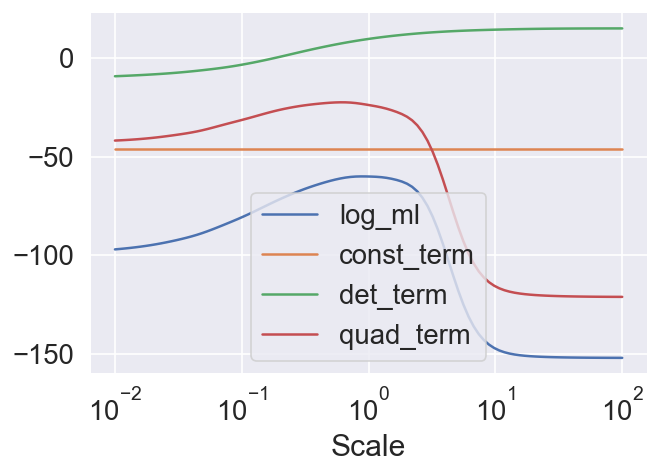

In [55]:
plt.figure(dpi=120)
plt.ylabel("Log")
plt.axes(xscale = "log")     
plt.xlabel("Scale")
plt.plot(scales, log_ml, label="log_ml")
plt.plot(scales, const_term, label="const_term")
plt.plot(scales, det_term, label="det_term")
plt.plot(scales, quad_term, label="quad_term")
plt.legend()
plt.show()

## 4e

In [53]:
mlppd = np.zeros(100)
for idx, value in enumerate(scales):
    mu, Sigma = predictive(Xp, Xval, yval, alpha, value, sigma2)
    mlppd[idx] = MLPPD(Xval, yval, mu, Sigma)

plt.figure(dpi=120)
plt.ylabel("Log")
plt.axes(xscale = "log")     
plt.xlabel("Scale")
plt.plot(scales, mlppd, label="mlppd")

plt.legend()
plt.show()

IndexError: index 50 is out of bounds for axis 0 with size 50